In [238]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from random import randint

## Generate rotated card

In [239]:
img = cv2.imread("svgtest.png")

def rotate_image(image, rotation_angle, center_points=None, revert=False):
    h, w = image.shape[:2]
    if center_points is None:
        cx, cy = (w // 2, h // 2)
    else:
        cx, cy = center_points
        
    # get rotation matrix 
    M = cv2.getRotationMatrix2D((cx, cy), rotation_angle, 1.0)

    # get cos and sin value from the rotation matrix
    cos, sin = abs(M[0, 0]), abs(M[0, 1])

    # calculate new width and height after rotation
    if revert:
        A = np.array([[sin, cos], [cos, sin]])
        B = np.array([h, w])
        X = np.linalg.inv(A).dot(B)
        newW, newH = X.astype('int')
    else: 
        newW = int((h * sin) + (w * cos))
        newH = int((h * cos) + (w * sin))

    # calculate new rotation center
    M[0, 2] += (newW / 2) - cx
    M[1, 2] += (newH / 2) - cy

    # use modified rotation center and rotation matrix in the warpAffine method
    return cv2.warpAffine(image, M, (newW, newH), borderMode=cv2.BORDER_CONSTANT,
                            borderValue=(255,255,255)) 
                

In [240]:
def get_contours(new_image):
    mask = cv2.inRange(new_image, 0, 150)

    # apply morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
    clean = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
    clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # get external contours
    contours = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    squares = []
    for c in contours:
        # get rotated rectangle from contour
        rot_rect = cv2.minAreaRect(c)
        if abs(rot_rect[1][0] - rot_rect[1][1]) < min(rot_rect[1]) / 50:
            squares.append(rot_rect)
    return squares

In [241]:
def calculate_delta(first_pos, second_pos):
        return abs(first_pos[0] - second_pos[0]), abs(first_pos[1] - second_pos[1])
        
def set_numeric_values_squares(contours):
    def is_similar(first_delta, second_delta):
        return abs(first_delta[0] - second_delta[0]) <= min(first_delta[0], second_delta[0]) / 100 and \
               abs(first_delta[1] - second_delta[1]) <= min(first_delta[1], second_delta[1]) / 100

    # Top       left: 4,                
    # Middle    left: 3
    # Bottom    left: 0,    middle 1,   right: 2
    # Page width = distance between 0 and 2
    # Page height = distance between 0 and 4
    
    # Find three squares lines 
    # (should be two, first vertical on left side, second horizontal on bottom)
    points = []
    for first_idx in range(len(contours)):
        first_point = contours[first_idx]
        for second_idx in range(first_idx + 1, len(contours)):
            second_point = contours[second_idx]
            for third_idx in range(second_idx + 1, len(contours)):
                third_point = contours[third_idx]
                fs_delta = calculate_delta(first_point[0], second_point[0])
                ft_delta = calculate_delta(first_point[0], third_point[0])
                st_delta = calculate_delta(second_point[0], third_point[0])
                if is_similar(fs_delta, st_delta):
                    points.append([first_point, second_point, third_point])
                elif is_similar(fs_delta, ft_delta):
                    points.append([second_point, first_point, third_point])  
                elif is_similar(st_delta, ft_delta):
                    points.append([first_point, third_point, second_point])
    
    assert len(points) == 2, "Didn't detect two lines of squares, can't rotate page"


    # Reorder points based on commonly shared sqare (0 index square)
    first_line = points[0]
    second_line = points[1]

    if first_line[0] == second_line[0]:
        pass
    elif first_line[2] == second_line[2]:
        first_line = first_line[::-1] 
        second_line = second_line[::-1] 
    elif first_line[0] == second_line[2]:
        second_line = second_line[::-1]
    elif first_line[2] == second_line[0]:
        first_line = first_line[::-1]
    
    # Calculate length of lines based on length of lines
    fl_x, fl_y = calculate_delta(first_line[0][0], first_line[2][0])
    sl_x, sl_y = calculate_delta(second_line[0][0], second_line[2][0])

    fl_dist = (fl_x ** 2 + fl_y ** 2) ** (1/2)
    sl_dist = (sl_x ** 2 + sl_y ** 2) ** (1/2)

    # Assign lines to proper values
    if fl_dist < sl_dist:
        horizontal_line = first_line
        vertical_line = second_line
    else:
        horizontal_line = second_line
        vertical_line = first_line

    # Assign indexes to proper squares
    numered_points = dict(enumerate([*horizontal_line, *vertical_line[1:]]))
    return numered_points

In [242]:
def find_middle_of_page(numered_points):
    zero_pos = np.array(numered_points[0][0])
    first_pos = np.array(numered_points[1][0])
    third_pos = np.array(numered_points[3][0])
    zero_to_one_distance = first_pos - zero_pos
    zero_to_three_distance = third_pos - zero_pos
    middle_from_one = first_pos + zero_to_three_distance
    middle_from_three = third_pos + zero_to_one_distance
    return (middle_from_one + middle_from_three) / 2
    
def find_angle_of_page(numered_squares):
    # Here we calculate distance between point 0 and point 1 (taking it as hypotenuse)
    # to divide it by x difference between point 0 and 1. 
    # We use it further to calculate alpha radius.
    zero_square = np.array(numered_squares[0][0])
    first_square = np.array(numered_squares[1][0])
    opposite_to_angle = zero_square[0] - first_square[0]
    hypotenuse = sum((zero_square - first_square) ** 2) ** (1/2)
    return math.asin(opposite_to_angle/hypotenuse) * 180 / math.pi

def calculate_quarter(numered_squares):
    # We base on calculating relative distance between 0 indexed point and 1
    # Feel free to print the page and rotate it to figure out quarters
    zs_x, zs_y = numered_squares[0][0]
    fs_x, fs_y = numered_squares[1][0]
    zs_x, zs_y = zs_x // 10, zs_y // 10
    fs_x, fs_y = fs_x // 10, fs_y // 10
    if zs_x >= fs_x:
        if zs_y >= fs_y:
            return 2
        else:
            return 3
    else:
        if zs_y >= fs_y:
            return 1
        else:
            return 4

def first_quarter(angle):
    if angle == 0:
        return angle
    if angle > 0:
        if angle < 45:
            angle += 90
        else:
            angle *= -1
    elif angle < 0:
        angle += 90
        if angle > 0:
            angle *= -1
    return angle   

def second_quarter(angle):
    return - angle - 90

def third_quarter(angle):
    return angle - 270

def forth_quarter(angle):
    return angle - 270 

def fix_angle(angle, quarter):
    quarter_fun = {
        1: first_quarter,
        2: second_quarter,
        3: third_quarter,
        4: forth_quarter
    }
    return quarter_fun[quarter](angle)

def pipeline(parsed_image):
    if len(parsed_image.shape) == 3:
        parsed_image = cv2.cvtColor(parsed_image, cv2.COLOR_RGB2GRAY)
    squares = get_contours(parsed_image)
    numered_squares = set_numeric_values_squares(squares)
    quarter = calculate_quarter(numered_squares)
    middle_pos = find_middle_of_page(numered_squares)
    new_angle = find_angle_of_page(numered_squares)
    new_angle = fix_angle(new_angle, quarter)
    return new_angle, middle_pos, quarter

In [243]:
def validation(image):
    guesses_hits = []
    quarter_modifiers = [list() for _ in range(4)]
    hits = 0
    test_angles = list(range(0, 360, 1))
    shots = len(test_angles)
    for random_angle in test_angles:
        temp_image = rotate_image(image, random_angle)
        detected_angle, _, quarter = pipeline(temp_image)
        # We assume the misscalculation between angle to be below 0.5 degree
        if random_angle + detected_angle < 0.5:
            hits += 1
        else:
            quarter_modifiers[quarter - 1].append([-random_angle, detected_angle, -random_angle-detected_angle])
            guesses_hits.append([-random_angle, detected_angle, quarter])
    if max([len(quarter) for quarter in quarter_modifiers]) > 0:
        for quarter in quarter_modifiers:
            print(quarter)
    else:
        print("Success!!!")
    return float(hits/shots)

In [244]:
results = validation(img)
print(results)

Success!!!
1.0


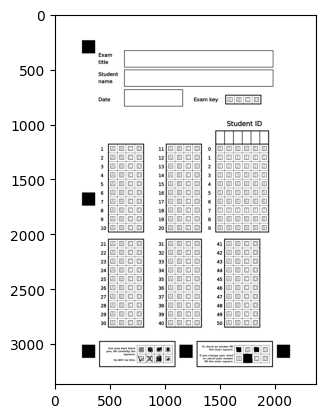

In [246]:
random_angle = randint(0, 359)
test_image = rotate_image(img, random_angle)
detected_angle, center_position, _ = pipeline(test_image)
result_image = rotate_image(test_image, detected_angle, center_position, True)
plt.imshow(result_image, cmap='gray', vmin=0, vmax=255);